In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.signal import butter, find_peaks, filtfilt, iirnotch
from scipy.signal import detrend
import pywt
import json

In [242]:
def bandpass_filter(ecg_signal, fs, lowcut=0.5, highcut=40.0, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

def bandstop_filter(ecg_signal, fs, lowcut=0.5, highcut=40.0, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandstop')
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

def notch_filter(ecg_signal, freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    notch_freq = freq / nyquist
    b, a = iirnotch(notch_freq, quality_factor, fs)
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

def wavelet_denoise(ecg_signal, wavelet='db6', level=4, threshold_mode="soft"):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    threshold = np.sqrt(2 * np.log(len(ecg_signal)))
    denoised_coeffs = [pywt.threshold(c, threshold, mode=threshold_mode) for c in coeffs]
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

def normalize_signal(ecg_signal):
    mean = np.mean(ecg_signal)
    std = np.std(ecg_signal)
    normalized_signal = (ecg_signal - mean) / std
    return normalized_signal

def crop(ecg_signal, interval, ts, tf):
    ts_i = np.argwhere(interval >= ts)[0][0]
    tf_i = np.argwhere(interval >= tf)[0][0]
    return ecg_signal[ts_i: tf_i], interval[ts_i: tf_i]

In [243]:
class EmgPreprocessing:
    def __init__(self, x, y, kf: float = None) -> None:
        self.x = x
        self.y = y * kf if kf is not None else y  #* (3100 - 150) / 1000 / 65535
    
    def baseline(self, time_point: float = None):
        baseline_idx = np.argwhere(self.x >= time_point)[0][0]
        baseline = self.y[:baseline_idx]
        x0 = np.mean(baseline)
        normalize = self.y - x0

        self.x = self.x[baseline_idx:]
        self.y = normalize[baseline_idx:]
        return self
    
    def bandpass(self, sfreq: float = 1000, low: float = 450, high: float = 20):
        high = high/(sfreq/2)
        low = low/(sfreq/2)
        b, a = butter(4, [high, low], btype='bandpass')
        self.y = filtfilt(b, a, self.y)
        return self
    
    def notch(self, freq: float = 50, sfreq: float = 1000):
        b, a = iirnotch(freq, 30.0, sfreq)
        self.y = filtfilt(b, a, self.y)
        return self
    
    def lowpass(self, sfreq: float = 1000, low: float = 10):
        low = low/(sfreq/2)
        b, a = butter(4, low, btype='lowpass')
        self.y = filtfilt(b, a, self.y)
        return self
    
    def rectification(self):
        self.y = np.abs(self.y)
        return self
    
    def power(self, mode) -> np.ndarray:
        if mode == "simps":
            return simpson(np.power(self.y, 2))

        if mode == "rms":
            return np.sqrt(np.mean(np.power(self.y, 2)))

        return simpson(np.power(self.y, 2))

In [244]:
FOLDER = "exo_on"
RECORD = "record_4"

with open(f"../data/orangepi/{FOLDER}/{RECORD}.json") as f:
    points = json.load(f)
df = pd.read_csv(f"../data/orangepi/{FOLDER}/{RECORD}.csv")
df.head()

,time,y1,y2,y3
0,0.006044,1980,293,403
1,0.008807,2053,799,301
2,0.011587,1799,880,339
3,0.014328,1498,272,198
4,0.017076,1340,1088,395


370


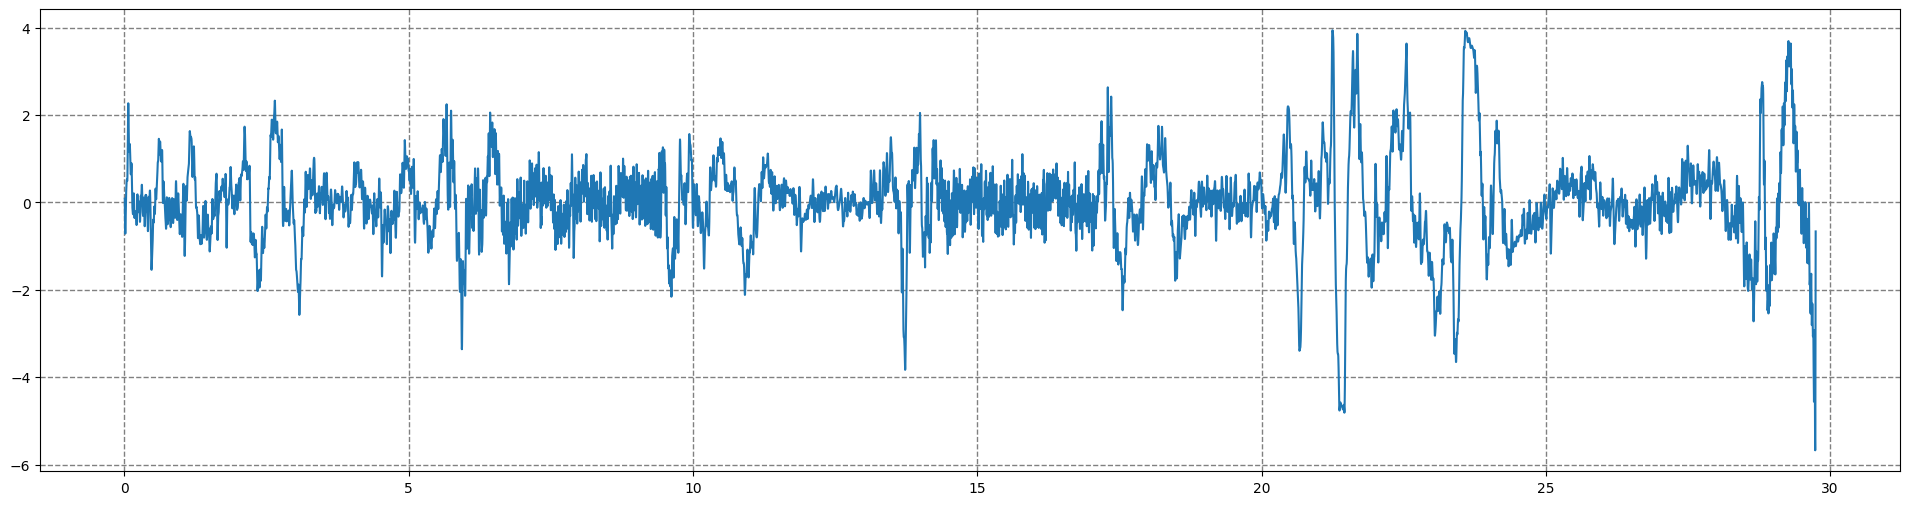

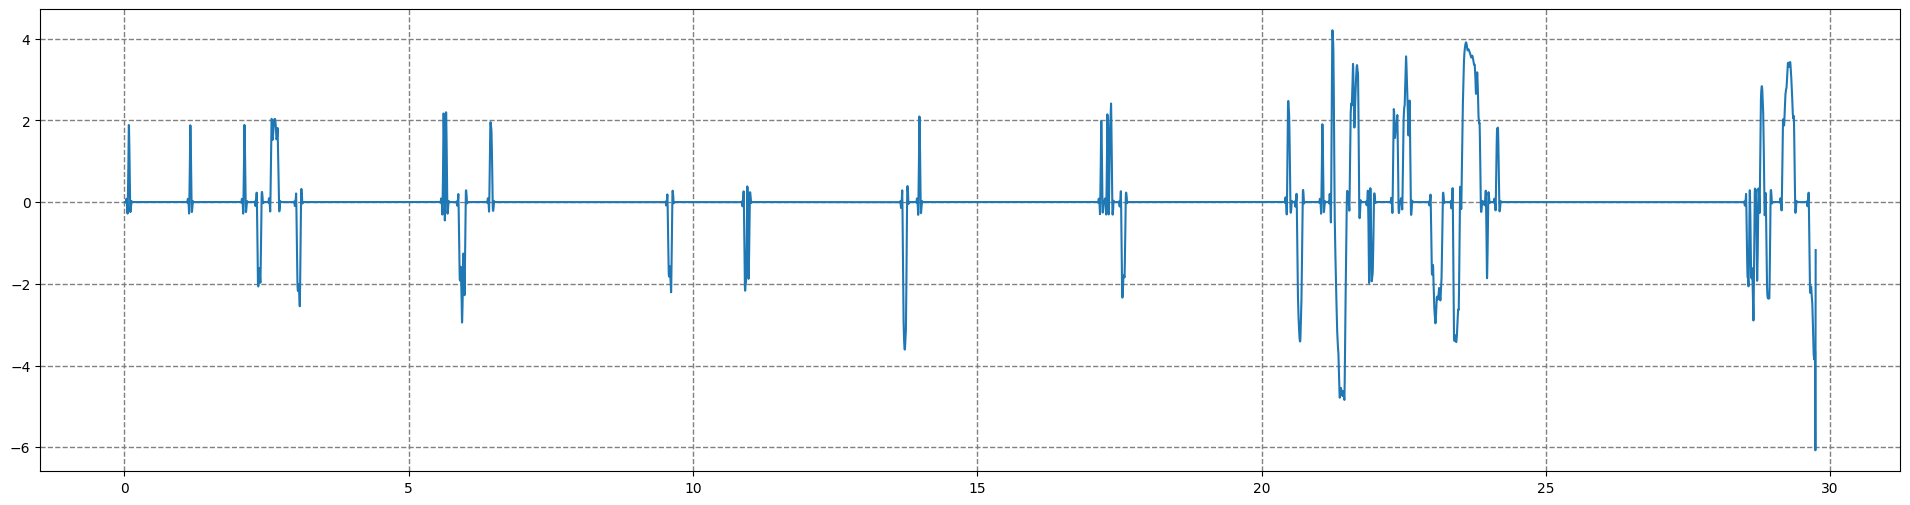

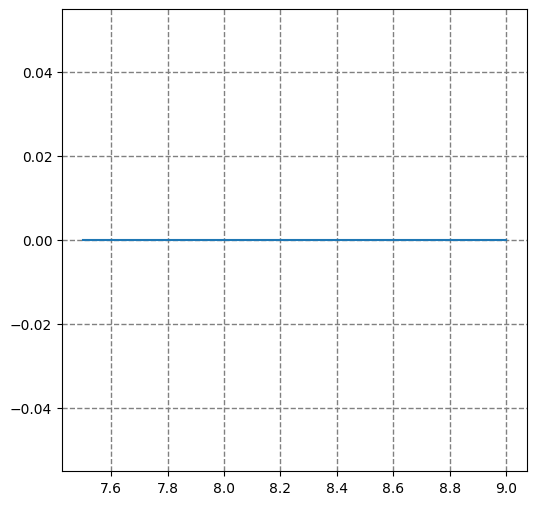

In [245]:
x_ecg = df["time"].to_numpy()
y_ecg = df["y1"].to_numpy() * (3.3 - 0.15) / 4095


freq = int((1 / (x_ecg[1:] - x_ecg[:-1])).mean())
print(freq)


y_ecg = detrend(y_ecg.copy())
y_ecg = bandpass_filter(y_ecg.copy(), freq)
y_ecg = notch_filter(y_ecg.copy(), freq, 50)
y_ecg = notch_filter(y_ecg.copy(), freq, 60)
y_ecg = notch_filter(y_ecg.copy(), freq, 100)
y_ecg = notch_filter(y_ecg.copy(), freq, 120)
y_ecg = normalize_signal(y_ecg.copy())

plt.figure(figsize=(24, 6))
plt.plot(x_ecg, y_ecg[:x_ecg.shape[0]])
plt.grid(linestyle="--", linewidth=1, c="gray")
plt.show()

# y_ecg = wavelet_denoise(y_ecg.copy(), "sym4", 3, "less")
y_ecg = wavelet_denoise(y_ecg.copy(), "sym4", 3, "hard")

plt.figure(figsize=(24, 6))
plt.plot(x_ecg, y_ecg[:x_ecg.shape[0]])
plt.grid(linestyle="--", linewidth=1, c="gray")
plt.show()

yd, xd = crop(y_ecg[:x_ecg.shape[0]], x_ecg[:x_ecg.shape[0]], 7.5, 9)
plt.figure(figsize=(6, 6))
plt.plot(xd, yd)
plt.grid(linestyle="--", linewidth=1, c="gray")
plt.show()

966.3843459862951


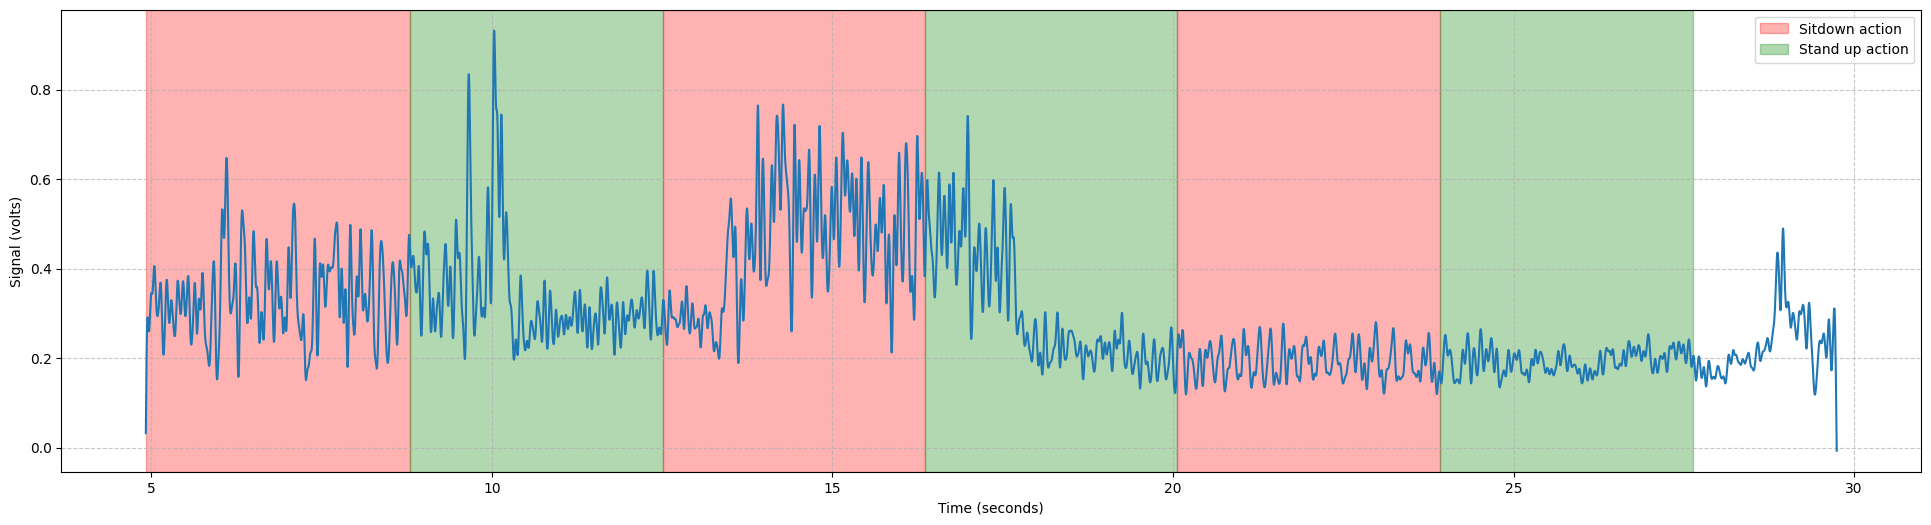

In [246]:
process = EmgPreprocessing(df["time"].to_numpy(), df["y2"].to_numpy(), 3.3 / 4095)
process.baseline(points[0]).bandpass(370*2.5, 400, 20).notch().rectification().lowpass(370 * 2.5, 40)

print(process.power("simps"))

c = ["r", "g"]
time = df["time"].to_numpy()
indexes = []
for point in points[1:]:
    indexes.append(np.argwhere(time >= point)[0][0])


plt.figure(figsize=(24, 6))
plt.plot(process.x, process.y)

for i in range(len(indexes) - 1):
    if i in [0, 1]:
        plt.axvspan(
            time[indexes[i]],
            time[indexes[i + 1]],
            color=c[i % 2],
            alpha=0.3,
            label=f"{'Sitdown action' if i%2==0 else 'Stand up action'}",
        )
    else:
        plt.axvspan(
            time[indexes[i]],
            time[indexes[i + 1]],
            color=c[i % 2],
            alpha=0.3,
        )

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal (volts)")
plt.legend()
plt.show()